In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

Data

In [2]:
# Load the data
data = pd.read_csv('HPG.csv', parse_dates=['Date'])

# Convert 'Price' column to numeric
data['Price'] = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce')

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Sort the index
data.sort_index(inplace=True)

# Set the frequency of the index
data = data.asfreq('B')

# Fill missing values if any (forward fill)
data['Price'].fillna(method='ffill', inplace=True)

# Split the data into training and testing sets
train_data = data[:'2022-02-28']
test_data = data['2022-03-01':'2023-03-31']

train = train_data['Price'].values
test = test_data['Price'].values

scaler1 = MinMaxScaler()
train_scaled = scaler1.fit_transform(train.reshape(-1, 1))
test_scaled = scaler1.transform(test.reshape(-1, 1))

scaler2 = StandardScaler()
train_scaled = scaler2.fit_transform(train_scaled.reshape(-1, 1))
test_scaled = scaler2.transform(test_scaled.reshape(-1, 1))
model_path = "LSTM_hpg.h5"

C:\Users\minht\AppData\Local\Temp\ipykernel_8268\1117795430.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Price'].fillna(method='ffill', inplace=True)


In [53]:
train_data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-01-02,11991.0,"11,789.9","12,003.6","11,676.8",15.73M,1.81%
2018-01-03,11965.9,"12,066.4","12,192.1","11,890.5",18.51M,-0.21%
2018-01-04,12116.7,"12,016.2","12,167.0","11,965.9",17.79M,1.26%
2018-01-05,12066.4,"12,091.6","12,179.6","11,978.4",14.03M,-0.42%
2018-01-08,12443.5,"11,991.0","12,443.5","11,940.7",14.19M,3.13%
...,...,...,...,...,...,...
2022-02-22,35116.6,"35,041.0","35,268.0","34,586.9",22.97M,-0.54%
2022-02-23,35343.7,"35,305.8","35,722.1","35,003.1",16.88M,0.65%
2022-02-24,34813.9,"35,381.5","35,457.2","34,132.8",29.18M,-1.50%


In [54]:
train_scaled[0]

array([-0.63755458])

In [55]:
train_scaled.shape

(1085, 1)

In [87]:
x_train, x_val = train_test_split(train_scaled, test_size=0.2, shuffle=False)
x_train.shape

(868, 1)

In [57]:
x_train[0]

array([-0.63755458])

In [88]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 20
train_generator = TimeseriesGenerator(x_train, x_train, length=n_input, batch_size=1)
val_generator = TimeseriesGenerator(x_val, x_val, length=n_input, batch_size=1)
train_generator[0]

(array([[[-0.63755458],
         [-0.63998267],
         [-0.62539479],
         [-0.63026064],
         [-0.59378127],
         [-0.5111005 ],
         [-0.54028593],
         [-0.54028593],
         [-0.53055423],
         [-0.46975528],
         [-0.43571367],
         [-0.49407486],
         [-0.43571367],
         [-0.34573896],
         [-0.2508984 ],
         [-0.2508984 ],
         [-0.2508984 ],
         [-0.30196565],
         [-0.24360446],
         [-0.30196565]]]),
 array([[-0.3068315]]))

Model

In [89]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_input, 1)))
model.add(Dense(1))  
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_weights_only=False,
    save_best_only=True,
    verbose=1
)

In [91]:
history = model.fit(train_generator, validation_data=val_generator, batch_size=16, epochs=30, callbacks=[checkpoint_callback, reduce_lr])

Epoch 1/30
841/848 [============================>.] - ETA: 0s - loss: 0.0537
Epoch 1: val_loss improved from inf to 0.18882, saving model to LSTM_hpg.h5
848/848 [==============================] - 6s 5ms/step - loss: 0.0533 - val_loss: 0.1888 - lr: 0.0100
Epoch 2/30
  1/848 [..............................] - ETA: 17s - loss: 0.0024

d:\Python\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


837/848 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 2: val_loss improved from 0.18882 to 0.13279, saving model to LSTM_hpg.h5
848/848 [==============================] - 4s 5ms/step - loss: 0.0045 - val_loss: 0.1328 - lr: 0.0100
Epoch 3/30
838/848 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 3: val_loss improved from 0.13279 to 0.04391, saving model to LSTM_hpg.h5
848/848 [==============================] - 4s 5ms/step - loss: 0.0028 - val_loss: 0.0439 - lr: 0.0100
Epoch 4/30
848/848 [==============================] - ETA: 0s - loss: 0.0024
Epoch 4: val_loss improved from 0.04391 to 0.02657, saving model to LSTM_hpg.h5
848/848 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0266 - lr: 0.0100
Epoch 5/30
845/848 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 5: val_loss did not improve from 0.02657
848/848 [==============================] - 4s 5ms/step - loss: 0.0022 - val_loss: 0.1800 - lr: 0.0100
Epoch 6/

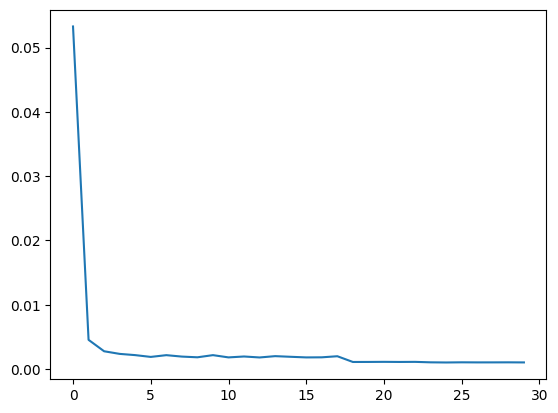

In [92]:
loss = model.history.history['loss']
plt.plot(range(len(loss)), loss)

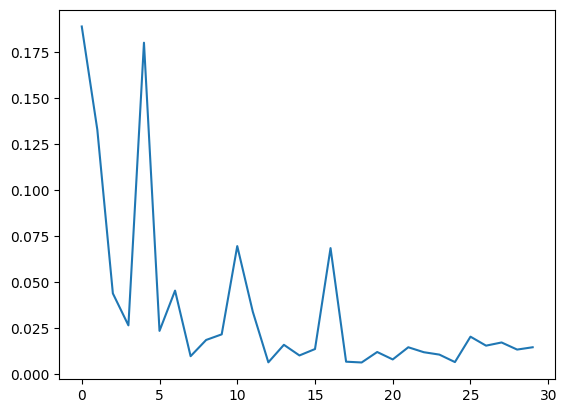

In [93]:
val_loss = model.history.history['val_loss']
plt.plot(range(len(val_loss)), val_loss)

Evaluation

In [3]:
model = tf.keras.models.load_model(model_path)

In [95]:
y_pred = model.predict(train_scaled)

34/34 [==============================] - 0s 1ms/step


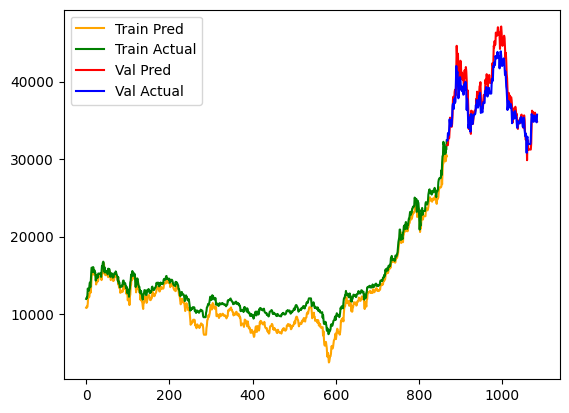

In [96]:
plot_pred = scaler2.inverse_transform(y_pred)
plot_train = scaler2.inverse_transform(x_train)
plot_val = scaler2.inverse_transform(x_val)
plot_pred = scaler1.inverse_transform(plot_pred)
plot_train = scaler1.inverse_transform(plot_train)
plot_val = scaler1.inverse_transform(plot_val)

plt.plot(range(len(x_train)-1), plot_pred[:len(x_train)-1], color ="orange", label = "Train Pred")
plt.plot(range(len(x_train)-1), plot_train[1:], color ="green", label = "Train Actual")
plt.plot(range(len(x_train)-1,len(train_scaled)-1), plot_pred[len(x_train)-1:-1], color ="red", label = "Val Pred")
plt.plot(range(len(x_train)-1,len(train_scaled)-1), plot_val, color ="blue", label = "Val Actual")
plt.legend()

In [4]:
data_scaled = np.concatenate((train_scaled, test_scaled))
pred = model.predict(data_scaled)
pred = pred[-len(test_scaled)-1:-1]

43/43 [==============================] - 0s 1ms/step


In [98]:
len(pred)

284

In [5]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math

plot_pred = scaler2.inverse_transform(pred)
actual = scaler2.inverse_transform(test_scaled)
plot_pred = scaler1.inverse_transform(plot_pred)
actual = scaler1.inverse_transform(actual)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


r2 = r2_score(test_scaled, pred)
print("R-squared:", r2)
mape = mean_absolute_percentage_error(actual, plot_pred)
print("MAPE:", mape)
rmse = math.sqrt(mean_squared_error(actual, plot_pred))
print("RMSE:", rmse)


R-squared: 0.9853048712610946
MAPE: 2.8790802036592646
RMSE: 769.5187108910271


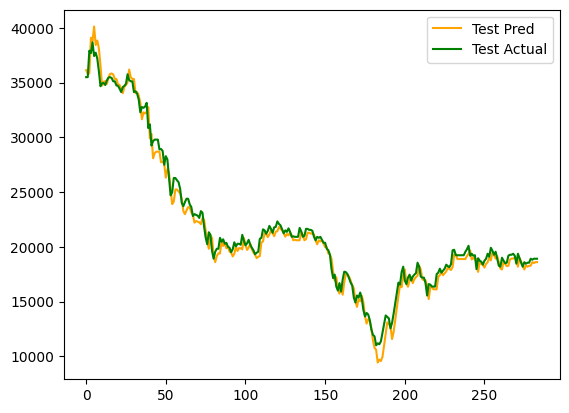

In [102]:
plt.plot(range(len(actual)), plot_pred, color ="orange", label = "Test Pred")
plt.plot(range(len(actual)), actual, color ="green", label = "Test Actual")
plt.legend()